In [1]:
import pandas as pd
import numpy as np
import torch
import sys
import os
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import TimesNet as tn
from utils import plots as plts
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'heating_demand', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)
data = df[features + targets]

In [2]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_tensor = torch.tensor(scaled_data, dtype=torch.float32).to(device)

train_size = int(len(data_tensor) * 0.8)
train_data = data_tensor[:train_size]
test_data = data_tensor[train_size:]

In [3]:
class Config:
    seq_len = 96
    label_len = 48
    pred_len = 24
    enc_in = len(features) + len(targets)
    c_out = len(targets)
    d_model = 64
    d_ff = 256
    e_layers = 2
    num_kernels = 3
    top_k = 2
    dropout = 0.1
    embed = 'timeF'
    freq = 'h'
    task_name = 'long_term_forecast'

configs = Config()


In [4]:
model = tn.Model(configs).to(device)
model.c_out = configs.c_out
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

def create_sequences(data_tensor, seq_len):
    sequences = []
    for i in range(len(data_tensor) - seq_len):
        sequences.append(data_tensor[i:i+seq_len])
    return torch.stack(sequences)

def prepare_decoder_input(x_enc, label_len, pred_len):
    batch_size, seq_len, feat_dim = x_enc.size()
    label_part = x_enc[:, -label_len:, :]
    pred_part = torch.zeros(batch_size, pred_len, feat_dim, device=x_enc.device)
    return torch.cat([label_part, pred_part], dim=1)

train_sequences = create_sequences(train_data, configs.seq_len)

batch_size = 16
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for i in range(0, len(train_sequences), batch_size):
        x_enc = train_sequences[i:i+batch_size].to(device)
        x_dec = prepare_decoder_input(x_enc, configs.label_len, configs.pred_len)

        optimizer.zero_grad()
        output = model(x_enc, None, x_dec, None)

        # Output shape: [batch, pred_len, c_out]
        # Target = ultimi pred_len passi solo sulle feature target
        target = x_enc[:, -configs.pred_len:, -configs.c_out:]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {epoch_loss / (len(train_sequences) // batch_size)}")

Epoch 1 - Loss: 0.7111561387777329
Epoch 2 - Loss: 1.6618752459685007
Epoch 3 - Loss: 0.5830104087789854
Epoch 4 - Loss: 0.5509166995684306
Epoch 5 - Loss: 0.5353996654351553
Epoch 6 - Loss: 0.5257526929179828
Epoch 7 - Loss: 0.5159024412433306
Epoch 8 - Loss: 0.5048999627431233
Epoch 9 - Loss: 0.47434546301762265
Epoch 10 - Loss: 0.36740113496780397


In [5]:
model.eval()
with torch.no_grad():
    output = model(x_enc, None, x_dec, None)
    forecast = output[:, -configs.pred_len:, -configs.c_out:]  # shape: [batch, pred_len, c_out]
    true = x_enc[:, -configs.pred_len:, -configs.c_out:]

In [6]:
forecast_np = forecast.cpu().numpy().reshape(-1, configs.c_out)
true_np = true.cpu().numpy().reshape(-1, configs.c_out)

In [7]:
def plot_timesnet(real, pred, targets, n_cols=2, percent=False):
    """
    Plot real vs predicted values for multiple target features, with error metrics.

    Params:
    - real: [n_samples, n_targets] numpy array of true values
    - pred: [n_samples, n_targets] numpy array of predicted values
    - targets: list of target feature names (order must match columns in real/pred)
    - n_cols: columns per row in subplot grid
    - percent: show errors as percentages
    """
    n_targets = len(targets)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axs = axs.flatten()

    for i, target in enumerate(targets):
        y_true = real[:, i]
        y_pred = pred[:, i]
        error = y_true - y_pred
        abs_error = np.abs(error)
        denom = y_true.max() - y_true.min()

        mae = abs_error.mean()
        std = abs_error.std()
        nmae = mae / denom
        nmse = (error**2).mean() / np.var(y_true)
        nrmse = np.sqrt((error**2).mean()) / denom
        nstd = std / denom

        if percent:
            nmae *= 100
            nmse *= 100
            nrmse *= 100
            nstd *= 100

        ax = axs[i]
        ax.scatter(y_true, y_pred, c=abs_error, cmap='coolwarm', s=15,
                   edgecolors='black', linewidths=0.3, alpha=0.7,
                   label=f"NMAE={nmae:.2f} | NMSE={nmse:.2f}\nNRMSE={nrmse:.2f} | NSTD={nstd:.2f}")
        ax.plot([y_true.min(), y_true.max()],
                [y_true.min(), y_true.max()], 'k--', linewidth=1)
        ax.set_title(f"Target: {target}", fontsize=12)
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=9, loc='best')

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


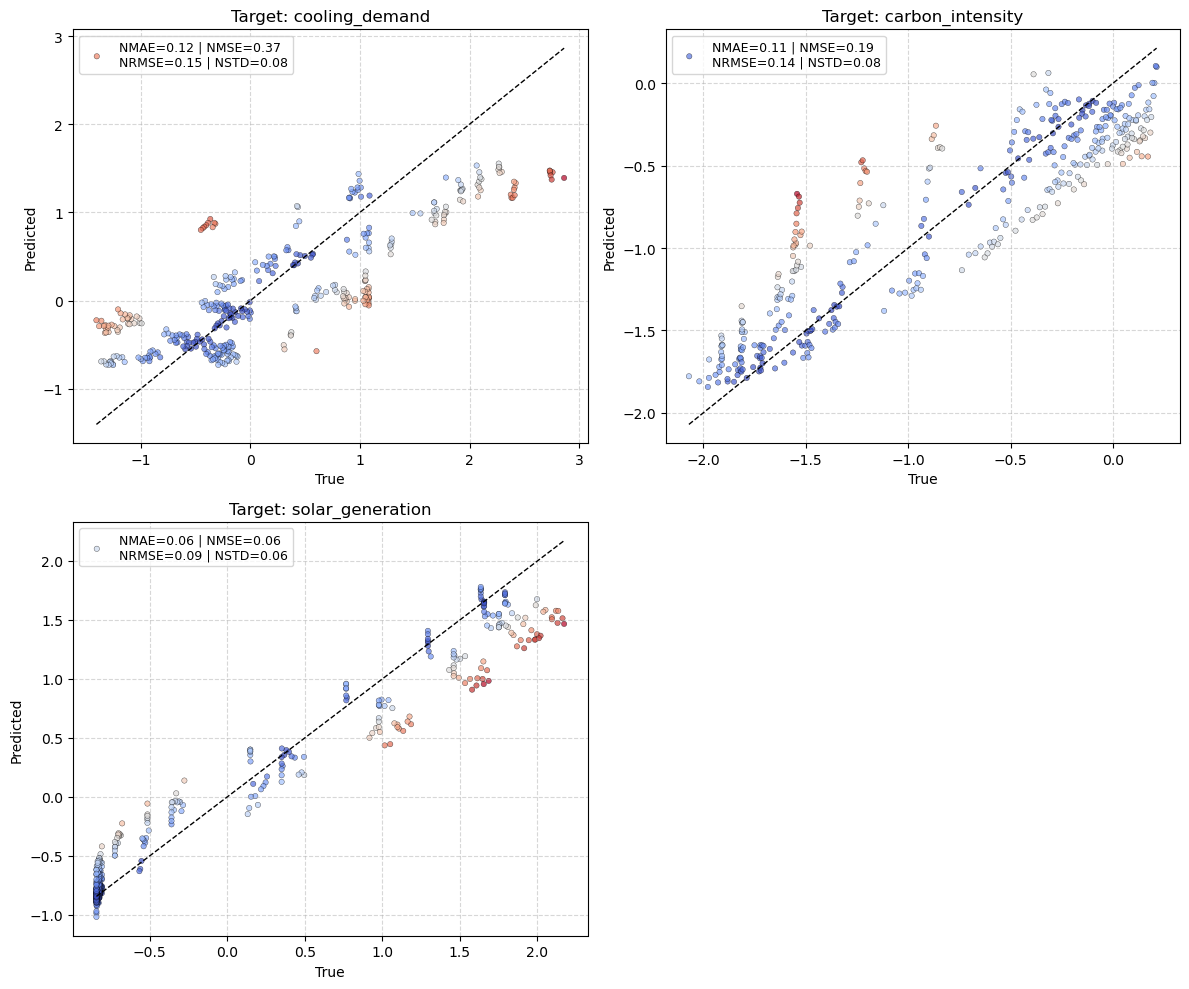

In [8]:
plot_timesnet(true_np, forecast_np, targets=targets)